In [7]:
import requests
import time
from IPython.display import JSON
import pandas as pd
import numpy as np 
from wordcloud import WordCloud, STOPWORDS
import panel as pn
pn.extension()
import param

import matplotlib.pyplot as plt
import plotly.express as px

import hvplot.pandas

import pickle
from io import StringIO


API_KEY = "c72ca91516524e6e96b8d985be6eda45"

In [35]:
endpoint = "https://api.assemblyai.com/v2/transcript"
audio_url = "https://github.com/thu-vu92/audio_analyzer_assemblyai/blob/main/How_I_Would_Learn_to_Code.mp3?raw=true"
audio_url_json = {
    "audio_url": audio_url,
    "sentiment_analysis": True,
    "auto_highlights": True,
    "iab_categories": True,
    "auto_chapters": True
}
headers = {
    "authorization": API_KEY,
    "content-type": "application/json"
}
transcript_response = requests.post(endpoint, json=audio_url_json, headers=headers)

result_endpoint = endpoint + '/' + transcript_response.json()["id"]
headers_auth = {
    "authorization": API_KEY,
}
response = requests.get(result_endpoint, headers=headers_auth)

while response.json()['status'] != "completed":
    response = requests.get(result_endpoint, headers=headers_auth)
    time.sleep(3)


gaata
gaata2


In [36]:
JSON(response.json())

<IPython.core.display.JSON object>

In [42]:
with open('speech_data.pkl', 'wb') as f:
    pickle.dump(response.json().copy(), f)
        
with open('speech_data.pkl', 'rb') as f:
    data = pickle.load(f)
    

## Building dashboard

### 0) Download transcript widget

In [101]:
buffer = StringIO()
buffer.write(data["text"])
buffer.seek(0)

0

In [106]:
transcript_download = pn.widgets.FileDownload(file=buffer, filename="transcript.txt")
transcript_download

FileDownload(file=<_io.StringIO o..., filename='transcript.txt', label='Download transcript.txt')

### 00) Audio play

In [39]:
audio_play = pn.pane.Audio(audio_url, name='Audio', time = 360)

audio_play

Audio(str, time=360)

### 1) Sentiment

In [43]:
sentiment = data["sentiment_analysis_results"]

In [44]:
sentiment_df = pd.DataFrame(sentiment)
sentiment_df.head()

,text,start,end,sentiment,confidence,speaker
0,I recently got an amazing opportunity.,250,2094,POSITIVE,0.985436,None
1,"I've been learning jujitsu, and a friend offer...",2252,7278,POSITIVE,0.567717,None
2,At this point in my life where I'm trying to i...,7424,13290,POSITIVE,0.955794,None
3,"In my personal opinion, I was all for until I ...",13340,22698,NEGATIVE,0.689610,None
4,"After all, it's been almost ten years since I ...",22844,26250,NEUTRAL,0.613529,None


In [46]:
sentiment_df_grouped = sentiment_df['sentiment'].value_counts()
sentiment_df_grouped

NEUTRAL     81
POSITIVE    53
NEGATIVE    16
Name: sentiment, dtype: int64

In [47]:
sentiment_plot = sentiment_df_grouped.hvplot(title = "Sentences by Sentiment Category", kind="bar")
sentiment_plot

:Bars   [index]   (sentiment)

In [104]:
positive_df = sentiment_df[sentiment_df["sentiment"] == "POSITIVE"][["text", "sentiment"]]
negative_df = sentiment_df[sentiment_df["sentiment"] == "NEGATIVE"][["text", "sentiment"]]
neutral_df = sentiment_df[sentiment_df["sentiment"] == "NEUTRAL"][["text", "sentiment"]]

sentiment_tabs = pn.Tabs(('Sentiment overview', sentiment_plot), 
                       ('Positive', pn.widgets.DataFrame(positive_df, autosize_mode='fit_columns', width=700, height=300)),
                       ('Negative', pn.widgets.DataFrame(negative_df, autosize_mode='fit_columns', width=700, height=300)),
                       ('Neutral', pn.widgets.DataFrame(neutral_df, autosize_mode='fit_columns', width=700, height=300))
                        )
sentiment_tabs

Tabs
    [0] HoloViews(Bars, name='Sentiment overview')
    [1] DataFrame(autosize_mode='fit_columns', height=300, sizing_mode='fixed', value=                          ..., width=700)
    [2] DataFrame(autosize_mode='fit_columns', height=300, sizing_mode='fixed', value=                          ..., width=700)
    [3] DataFrame(autosize_mode='fit_columns', height=300, sizing_mode='fixed', value=                          ..., width=700)

### 2) Word cloud

In [56]:
stopwords = set(STOPWORDS)

In [57]:
transcript = data["text"]

In [58]:
transcript_lower = [item.lower() for item in str(transcript).split()]

In [59]:
all_words = ' '.join(transcript_lower) 

In [60]:
all_words

"i recently got an amazing opportunity. i've been learning jujitsu, and a friend offered to coach me in exchange for teaching him how to code. at this point in my life where i'm trying to improve my jiu jitsu as quickly as possible, this was an incredible trade for me. in my personal opinion, i was all for until i had to think about how i'd actually go about teaching someone how to code starting from nothing, i quickly realized that this was going to be a lot harder than i thought. after all, it's been almost ten years since i wrote my very first line of code. that's a pretty long time. now, this video is about the very specific and detailed plan that i wrote for my friend to teach me the basics of coding for data science. since i did all the work for him, i figured i might as well share the details with you as well. here. there have been plenty of other great videos similar to this about how to start coding, and i've linked many of them in the description. again, those are great, but 

In [61]:
print("wordcloud")

class Controller(param.Parameterized):
    word_slider = param.Integer(30, bounds=(5, 50), step=5)

controller = Controller()

@pn.depends(controller.param.word_slider, watch=True)
def update_wordcloud(num_words):
    wordcloud = WordCloud(background_color='black', stopwords = stopwords, max_words = num_words,
                          colormap='viridis', collocations=False).generate(all_words)

    wordcloud_plot = px.imshow(wordcloud) 
    # Remove labels on axes
    wordcloud_plot.update_xaxes(showticklabels=False)
    wordcloud_plot.update_yaxes(showticklabels=False)
    
    return wordcloud_plot

wordcloud


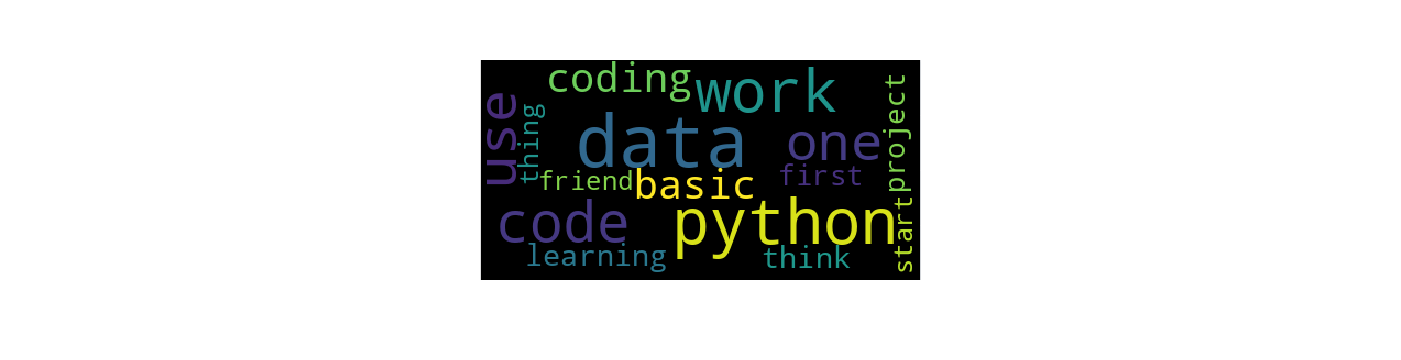

In [87]:
wordcloud = WordCloud(background_color='black', stopwords = stopwords, max_words = w_slider.value,
                      colormap='viridis', collocations=False).generate(all_words)

wordcloud_plot = px.imshow(wordcloud) 
# Remove labels on axes
wordcloud_plot.update_xaxes(showticklabels=False)
wordcloud_plot.update_yaxes(showticklabels=False)

### 3) Auto highlights

In [63]:
print("highlights")

highlights


In [90]:
highlights = data["auto_highlights_result"]["results"]
highlights_df = pd.DataFrame(highlights)
highlights_df

,count,rank,text,timestamps
0,1,0.07,Python code,"[{'start': 270164, 'end': 270870}]"
1,7,0.06,data science,"[{'start': 33404, 'end': 33934}, {'start': 679..."
2,1,0.06,data science learning,"[{'start': 88916, 'end': 89730}]"
3,1,0.06,tangible data science skills,"[{'start': 470132, 'end': 471394}]"
4,1,0.05,different data structures,"[{'start': 329504, 'end': 330478}]"
5,1,0.05,other great videos,"[{'start': 38756, 'end': 39522}]"
6,1,0.05,data types,"[{'start': 323264, 'end': 323986}]"
7,1,0.05,data frames,"[{'start': 412388, 'end': 412930}]"
8,2,0.05,Data scientists,"[{'start': 100412, 'end': 101146}, {'start': 1..."
9,2,0.05,other people,"[{'start': 540032, 'end': 540414}, {'start': 5..."


In [91]:
highlights_df_grouped = highlights_df.groupby(["count", "rank"])['text'].apply(", \n".join).reset_index()
highlights_df_grouped

,count,rank,text
0,1,0.05,"different data structures, \nother great video..."
1,1,0.06,"data science learning, \ntangible data science..."
2,1,0.07,Python code
3,2,0.05,"Data scientists, \nother people, \nmany people"
4,3,0.04,object oriented programming
5,6,0.04,projects
6,7,0.06,data science


In [92]:
highlights_plot = highlights_df_grouped.hvplot.points(x="count", y="rank", padding=0.4, hover_cols='all', width=1300, height = 600, size = 50, title = "Automatic Highlighted Words") *\
highlights_df_grouped.hvplot.labels(x="count", y="rank", text="text", text_baseline='top', hover=False).opts(fontscale=1.5)
highlights_plot

:Overlay
   .Points.I :Points   [count,rank]   (index,text)
   .Labels.I :Labels   [count,rank]   (text)

### 4) Auto chapter

In [73]:
chapters = data["chapters"]

In [74]:
chapters

[{'summary': "A friend offered to coach me in exchange for teaching him how to code. It's been almost ten years since I wrote my first line of code. This video is about the detailed plan that I wrote for him to teach me the basics of coding for data science.",
  'headline': 'A friend offered to coach me in exchange for teaching him how to code.',
  'gist': 'How to start coding from nothing.',
  'start': 250,
  'end': 57666},
 {'summary': "Python is more popular than R. For data scientists, it's more intuitive and flexible than R. It will be a more valuable skill to have for the job market in general and for the data science industry in particular. It is growing and will be more popular from 2020 to 2021.",
  'headline': 'Python is growing and will be more popular from 2020 to 2021.',
  'gist': 'Python vs r for data scientists.',
  'start': 57728,
  'end': 128946},
 {'summary': 'After choosing Python as a programming language, the first thing to do is to choose the right environment for

In [75]:
chapter = pn.widgets.StaticText(value=chapters[0]["summary"], width=1000, height_policy = "fit")

In [76]:
chapter

StaticText(height_policy='fit', value="A friend offered t..., width=1000)

In [77]:
button = pn.widgets.Button(name=str(int(chapters[0]["start"]/1000)), button_type='primary')
button

Button(button_type='primary', name='0')

In [78]:
chapters[0]

{'summary': "A friend offered to coach me in exchange for teaching him how to code. It's been almost ten years since I wrote my first line of code. This video is about the detailed plan that I wrote for him to teach me the basics of coding for data science.",
 'headline': 'A friend offered to coach me in exchange for teaching him how to code.',
 'gist': 'How to start coding from nothing.',
 'start': 250,
 'end': 57666}

In [80]:
start_time = 6430
chapter_audio = pn.pane.Audio(audio_url, name='Audio', time = round(start_time/1000))

In [98]:
# Create a layout for showing chapter summary and the time.
chapters_layout = pn.Column(pn.pane.Markdown("### Auto Chapter Summary"))

class ButtonAudio():
    def __init__(self, start_time):
        self.start_time = start_time
        self.button = pn.widgets.Button(name=str(round(self.start_time/1000, 2)), button_type='primary', width=60)
        self.chapter_audio = pn.pane.Audio(audio_url, name='Audio', time = round(self.start_time/1000))
        self.button.on_click(self.move_audio_head)

    def move_audio_head(self, event):
        # self.chapter_audio = pn.pane.Audio(filename, name='Audio', time = round(self.start_time/1000))
        # self.chapter_audio.paused = True
        self.chapter_audio.time = self.start_time/1000
        # self.button.name = "heeloo"

for chapter in chapters:
    chapter_summary = pn.widgets.StaticText(value=chapter["summary"], width=1000, height_policy = "fit")
    button_audio = ButtonAudio(chapter["start"])
    button = button_audio.button
    chapter_audio = button_audio.chapter_audio
    chapters_layout.append(pn.Row(pn.Column(button), pn.Column(chapter_audio), pn.Column(chapter_summary)))

In [99]:
chapters_layout

Column
    [0] Markdown(str)
    [1] Row
        [0] Column
            [0] Button(button_type='primary', name='0.25', width=60)
        [1] Column
            [0] Audio(str)
        [2] Column
            [0] StaticText(height_policy='fit', value="A friend offered t..., width=1000)
    [2] Row
        [0] Column
            [0] Button(button_type='primary', name='57.73', width=60)
        [1] Column
            [0] Audio(str, time=58)
        [2] Column
            [0] StaticText(height_policy='fit', value="Python is more popular th..., width=1000)
    [3] Row
        [0] Column
            [0] Button(button_type='primary', name='129.01', width=60)
        [1] Column
            [0] Audio(str, time=129)
        [2] Column
            [0] StaticText(height_policy='fit', value='After choosing Python as ..., width=1000)
    [4] Row
        [0] Column
            [0] Button(button_type='primary', name='272.52', width=60)
        [1] Column
            [0] Audio(str, time=273)
        [2] Column
            [0] StaticText(height_policy='fit', value="There's a common misconce..., width=1000)
    [5] Row
        [0] Column
            [0] Button(button_type='primary', name='522.46', width=60)
        [1] Column
            [0] Audio(str, time=522)
        [2] Column
            [0] StaticText(height_policy='fit', value='After learning the basics..., width=1000)

## Dashboard

In [107]:
# Dashboard template
template = pn.template.FastListTemplate(
    title='Audio Content Explorer', 
    sidebar=[pn.pane.Markdown("# Explore audio content"), 
             pn.pane.Markdown("#### This app analyzes the content of your audio file, including sentiment, wordcloud, automatic content summary and highlights."),
             pn.pane.Markdown("#### This app analyzes the content of your audio file, including sentiment, wordcloud, automatic content summary and highlights."),
             pn.pane.Markdown("### Download transcript"),
             transcript_download
             ],
    main=[pn.Row(pn.Column(sentiment_tabs), pn.Column(pn.Row(controller.param.word_slider), 
                                                      pn.Row(update_wordcloud, title = "WordCloud of Speech Content"))
                ),
          pn.Row(chapters_layout),
          pn.Row(highlights_plot, title = "Automatic Highlights")],
    accent_base_color="#88d8b0",
    header_background="#88d8b0",
)

template.show()

Launching server at http://localhost:64142
